In [1]:
# imports 

# make notebook span full width of window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] + "Dragonfly44_SFH/" # hack, but works
path_fits = path_base+ "fitting/output/fits/"
path_data = path_base+ "data/"

import numpy as np

from figure_style import *
from copy import deepcopy


In [2]:
# contains filenames of Prospector output
from Dragonfly44_SFH.fitting.output.fits.fits_DF44_summary import *

from Dragonfly44_SFH.utils.prospect_io import read_results

file_data = path_data+'DF44/obs_phot_specKCWI_sigma110.h5' # needed to rebuild model


In [3]:
showpars = ['mwa','t50','t90','logzsol','dust2']# 
showpar_labels = [r'$t_\mathrm{age}$ (Gyr, Lookback time)',\
                  r'$t_\mathrm{50}$ (Gyr)',
                  r'$t_\mathrm{90}$ (Gyr)',\
                  r'$\log(~Z_\ast/\mathrm{Z}_\odot~)$',\
                  r'$\hat{\tau}_\mathrm{dust,~diffuse}$']
ranges = [ (0,14), (0,14), (0,14), (-2,0.2), (0,4) ]


In [4]:
# build model to get prior draws

result_file = path_fits+ fit_aD1_phot_specKCWI
file_data = path_data+'DF44/obs_phot_specKCWI_sigma110.h5' # needed to rebuild model
result, obs, model = read_results( result_file, file_data=file_data )
zobs = float(model.params['zred'])

from Dragonfly44_SFH.utils.prospect_io import get_prior_draws
prior_draws = get_prior_draws( model, params=showpars, size=int(1e5) )

In [5]:

from Dragonfly44_SFH.utils import transforms
def get_posts( result, showpars, **extras ):
    from Dragonfly44_SFH.utils import transforms

    posts = []
    for par in showpars:

        if par in result['theta_index'].keys():
            x = transforms.chain_to_param( param=par, **result )

        elif par.startswith('t'):
            try:
                qt = float( par[1:] )/100.
                x = transforms.chain_to_quantiles( cmf_quantiles=[qt], **result)
            except:
                pass
        else:
            print('Dont know what to do with {}'.format(par))
            x = np.full_like( result['chain'][:,0], np.nan )


        x = np.squeeze(x)
        posts.append(x)

    from dynesty.utils import resample_equal
    wposts = resample_equal( np.stack(posts).T, result['weights'] )
    
    return wposts

def make_results( result_file, showpars=[], ddict=None, ddict_key=None, verbose=True ):
    from Dragonfly44_SFH.utils.prospect_io import read_results
    result,obs,_ = read_results( result_file )
    
    if ddict is None: 
        ddict = {}
        
    ddict['result_file'] = result_file
    if 'posts' not in ddict.keys(): ddict['posts'] = {}
        
    wposts = get_posts( result, showpars )
    for par,wp in zip( showpars, wposts.T ):
        ddict['posts'][par] = wp
            
    if obs['spectrum'] is not None:
         snr_spec = ( obs['spectrum']/obs['unc'] )[obs['mask']]
    else: snr_spec = [np.nan]
    ddict['snr'] = snr_spec
#     np.median( snr_spec )    

    return ddict


In [6]:
label = 'Extended'

fits = {'spec':{}, 'phot':{}, 'both':{} }

# it's okay that the model will fail to load
# we don't need it here
# if it is needed, provide file_data

fits['phot'] = make_results( path_fits+ fit_aD1_phot, showpars )

fits['spec']['full'] = make_results( path_fits+ fit_aD1_specKCWI_freemass, showpars )
fits['spec']['snr5'] = make_results( path_fits+ fit_aD1_specKCWI_snr5, showpars )
fits['spec']['snr10'] = make_results( path_fits+ fit_aD1_specKCWI_snr10, showpars )
fits['spec']['snr15'] = make_results( path_fits+ fit_aD1_specKCWI_snr15, showpars )
fits['spec']['snr20'] = make_results( path_fits+ fit_aD1_specKCWI_snr20, showpars )

fits['both']['full'] = make_results( path_fits+ fit_aD1_phot_specKCWI, showpars )
fits['both']['snr5'] = make_results( path_fits+ fit_aD1_phot_specKCWI_snr5, showpars )
fits['both']['snr10'] = make_results( path_fits+ fit_aD1_phot_specKCWI_snr10, showpars )
fits['both']['snr15'] = make_results( path_fits+ fit_aD1_phot_specKCWI_snr15, showpars )
fits['both']['snr20'] = make_results( path_fits+ fit_aD1_phot_specKCWI_snr20, showpars )


Error: failed to produce model
Error: failed to produce model
Error: failed to produce model
Caution: No logmass or massmet/massmet_1 or total_mass parameter!
Error: failed to produce model
Caution: No logmass or massmet/massmet_1 or total_mass parameter!
Error: failed to produce model
Caution: No logmass or massmet/massmet_1 or total_mass parameter!
Error: failed to produce model
Caution: No logmass or massmet/massmet_1 or total_mass parameter!
Error: failed to produce model
Error: failed to produce model
Error: failed to produce model
Error: failed to produce model
Error: failed to produce model


In [7]:
fits['phot']['plot_params'] = dict( mec='k', mfc='w', fmt=' ', marker='o', ecolor='gold', ms=10, elinewidth=2.2, capthick=2, lw=10 )
fits['spec']['plot_params'] = dict( mec='k', mfc='w', fmt=' ', marker='s', ecolor='c', elinewidth=1.5, capthick=1.5, ms=8 )
fits['both']['plot_params'] = dict( mec='k', mfc='r', fmt=' ', marker='D', ecolor='r', ms=8 )

color_prior = '0.3'

from matplotlib.legend_handler import HandlerErrorbar
import matplotlib.patheffects as fx


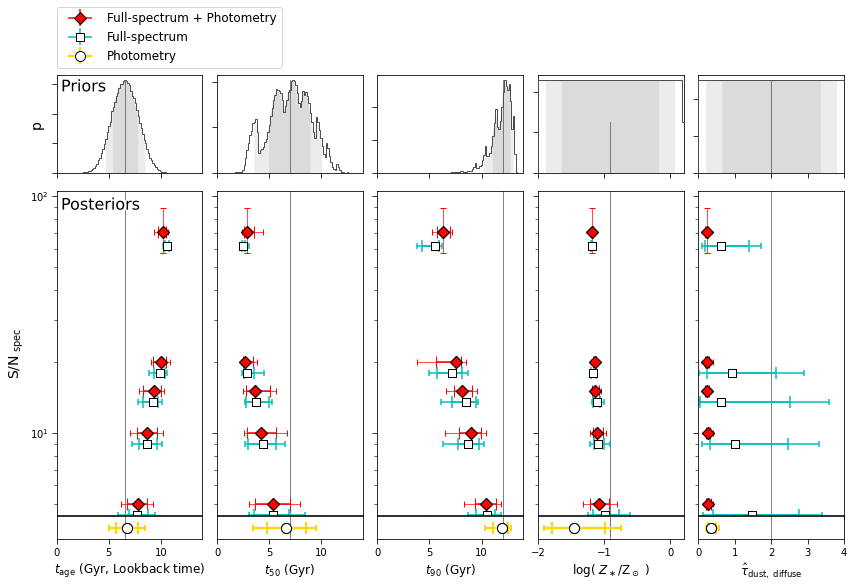

In [8]:

Npars = len(showpars)
quantiles = [0.05,0.16,0.5,0.84,0.95]

if True: # figure tweaks
    
    fig, axes = plt.subplots(4,Npars,figsize=(fig_width_two,0.45*textheight), \
                             gridspec_kw={'height_ratios':[0.3,0.05,1,0.07]}, sharex=False, sharey=False )
    axes1 = axes[0,:].flatten().tolist() 
    axes_off = axes[1,:].flatten().tolist() 
    axes2 = axes[2,:].flatten().tolist() 
    axes3 = axes[3,:].flatten().tolist() 
        
    for ax in axes_off:
        ax.axis('off')
        
    for ax in axes1+axes2+axes3:    
        ax.tick_params(direction='out', length=5, which='major')
        ax.tick_params(direction='out', length=3, which='minor')
        
    fig.subplots_adjust( wspace=0.1, hspace=0.01 )
    
if True: # priors
    
    for ii in range(Npars):
        par = showpars[ii]
        ax1 = axes1[ii]
        bin_range = ranges[ii]

        bins = np.linspace( bin_range[0], bin_range[1], 100 )
        n, b,_ = ax1.hist( prior_draws[par], bins=bins, histtype='step', color=color_prior, orientation='vertical', density=True, zorder=3 )
        nl = np.zeros_like(n)
        b=b[:-1]

        qs = np.quantile( prior_draws[par], q=quantiles )
        sel = (qs[0]<b)&(b<qs[-1])
        ax1.fill_between( b[sel], nl[sel], n[sel], color=color_prior, lw=0, alpha=0.1, zorder=0  )
        sel = (qs[1]<b)&(b<qs[-2])
        ax1.fill_between( b[sel], nl[sel], n[sel], color=color_prior, lw=0, alpha=0.1, zorder=1  )
        sel = np.argmin(np.abs( n - qs[2] ))
        ax1.plot( [qs[2],qs[2]],[0,n[sel]], color=color_prior, lw=0.7, zorder=2 )
        
        axes2[ii].axvline( qs[2], color=color_prior, lw=0.7, zorder=-10 )
        axes3[ii].axvline( qs[2], color=color_prior, lw=0.7, zorder=-10 )
                
if True: # phot 
    
    for ii in range(Npars):
        par = showpars[ii]
        ax2 = axes3[ii]

        qs = np.quantile( fits['phot']['posts'][par], q=quantiles )

        y_snr = 0
        ax2.set_ylim(-1.2,1.2)
        xerr1 = [[qs[2]-qs[0]],[qs[-1]-qs[2]]]
        xerr2 = [[qs[2]-qs[1]],[qs[-2]-qs[2]]]
        
        ax2.errorbar( qs[2], y_snr, yerr=0, xerr=xerr1, zorder=1, capsize=3, **fits['phot']['plot_params']  )
        ax2.errorbar( qs[2], y_snr, yerr=0, xerr=xerr2, zorder=1, capsize=6, **fits['phot']['plot_params']  )
        
if True: # both+specs 
    for snr_key in [ 'snr5','snr10','snr15','snr20','full' ]: 
        for i,key in enumerate(['both','spec']):
            
            snr = fits[key][snr_key]['snr']
            qs_snr_obs =  np.quantile( snr, q=[0.16,0.5,0.84] )
            if i>0:  dqs_snr_obs = 0
            else:    dqs_snr_obs = np.diff( qs_snr_obs ).reshape(2,-1)
            y_snr = qs_snr_obs[1] - i*0.1*qs_snr_obs[1]
            
            for ii,par in enumerate(showpars):
#                 if (par in ['dust2']) and (key in ['spec']): continue
                
                ax2 = axes2[ii]

                qs = np.quantile( fits[key][snr_key]['posts'][par], q=quantiles )
                xerr1 = [[qs[2]-qs[0]],[qs[-1]-qs[2]]]
                xerr2 = [[qs[2]-qs[1]],[qs[-2]-qs[2]]]

                ax2.errorbar( qs[2], y_snr, yerr=dqs_snr_obs, xerr=xerr1, zorder=1, capsize=3, lw=0.7, 
                              **fits[key]['plot_params']  )
                ax2.errorbar( qs[2], y_snr, yerr=None,        xerr=xerr2, zorder=1, capsize=6, 
                              **fits[key]['plot_params']  )
                
if True: # legend 
    
    ax = axes[0,0]
    xlim,ylim = ax.get_xlim(), ax.get_ylim()
    
#     ax.errorbar( [-1],[-1],xerr=[1], yerr=[1], **params_both, label='Full-spectrum + SED')
#     ax.errorbar( [-1],[-1],xerr=[1], yerr=[1], **params_spec, label='Full-spectrum')
    xys = [ [-1],[-1],[15],[1] ]
    h1 = ax.errorbar( *xys, **fits['both']['plot_params'], label='Full-spectrum + Photometry')
    h2 = ax.errorbar( *xys, **fits['spec']['plot_params'], label='Full-spectrum')
    h3 = ax.errorbar( *xys, **fits['phot']['plot_params'], label='Photometry')
    
    handler_map={ type(h1): HandlerErrorbar(xerr_size=1, yerr_size=0.7),
                  type(h2): HandlerErrorbar(xerr_size=1, yerr_size=0.7),
                  type(h3): HandlerErrorbar(xerr_size=1, yerr_size=0.7),
                }
    
#     ax.fill_between( [],[],color='k', alpha=0.5, label='Photometry')
    ax.legend(loc=3, handlelength=3, fontsize=12, bbox_to_anchor=[-0.04,1.02],
              handler_map=handler_map,  # adjust xerr_size to suit the plot
             )    
    
    ax.set_xlim( xlim ) 
    ax.set_ylim( ylim )
        
if True: # tweaks
    
    for ii in range(Npars):
        axes1[ii].set( xlim=ranges[ii], xticklabels=[], yticklabels=[] )
        axes2[ii].set( xlim=ranges[ii], xticklabels=[], )
        axes3[ii].set( xlim=ranges[ii], yticklabels=[], yticks=[] )
        axes2[ii].set( xlim=ranges[ii], yscale='log', ylim=(4.5,105) ) 
        
        axes3[ii].set_xlabel( showpar_labels[ii] ) 
        if ii>0:
            axes2[ii].set_yticklabels([])
    
    axes2[0].set_ylabel(r"S/N$_\mathrm{~spec}$", fontsize=14 )        
    axes1[0].set_ylabel("p", fontsize=14 )        

ann_params = dict( xy=(0,0), xycoords='axes fraction', ha='left', va='top', fontsize=16)
text = axes1[0].annotate('Priors', xytext=(0.03,0.96), **ann_params )
text.set_path_effects([ fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal() ])
text = axes2[0].annotate('Posteriors', xytext=(0.03,0.98), **ann_params )
text.set_path_effects([ fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal() ])
    
    
plt.savefig( "figures/figB4.pdf", **saveparams )
plt.show()

Note that in the figure published in Webb+2022, the markers for spec+phot and spec-only were swapped...

Hence the uncertainties on the dust2 values **were** erroneous (reflecting that the spectrum alone, which had it's continuum flattened, provides no constraints on the dust!)